# Architecture Comparison: IT Ticket Classification

Exploração e comparação de arquiteturas para classificação de tickets (RNN, LSTM, GRU, BiLSTM, BiGRU, KNN) usando dados processados que **não** estão na amostra do pipeline principal (`sample_200.csv`). Inclui EDA, split estratificado train/val e tabela final de métricas.

**Dataset:** [IT Service Ticket Classification](https://www.kaggle.com/datasets/adisongoh/it-service-ticket-classification-dataset) (Kaggle).  
**Autor do dataset:** **adison_goh** (Adison Goh).

Contents:
1. Setup, load data (excl. sample_200), EDA e gráficos
2. Pré-processamento, estratificação e split train/val
3. RNN, LSTM, GRU, BiLSTM, BiGRU, KNN
4. Tabela comparativa de métricas

# 1. Data Pre-Processing

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import random

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
from pathlib import Path

ROOT = Path(".").resolve()
if not (ROOT / "data").exists():
    ROOT = ROOT.parent
dataset_path = ROOT / "data" / "processed" / "dataset_with_id.csv"
sample_path = ROOT / "data" / "processed" / "sample_200.csv"

df_full = pd.read_csv(dataset_path)
sample_ids = set(pd.read_csv(sample_path)["id"].astype(str))
df = df_full[~df_full["id"].astype(str).isin(sample_ids)].copy()
df = df.reset_index(drop=True)
tickets_df = df
print(f"Loaded {len(tickets_df)} rows (excluding {len(sample_ids)} sample_200 ids)")
tickets_df.head()

Loaded 47637 rows (excluding 200 sample_200 ids)


,id,Document,Topic_group
0,955b360655e397cd,connection with icon icon dear please setup ic...,Hardware
1,746b81ebcbbe51c2,work experience user work experience user hi w...,Access
2,541dda5305f665de,requesting for meeting requesting meeting hi p...,Hardware
3,135ce82eb3f59884,reset passwords for external accounts re expir...,Access
4,f036726ad147dc2b,mail verification warning hi has got attached ...,Miscellaneous


### i. Text Exploration

The dataset consists of 47637 rows and 3 columns.

The id column with an unique hash id.
The 'Document' column contains the full text of the e-service ticket that was  logged.

The 'Topic_group' columns contains the classification or topic of the ticket. <br>There are 8 possible topics - 'Hardware', 'Access', 'Storage', 'Internal Project', 'HR Support', 'Administrative rights', 'Purchase', 'Miscellaneous'.

In [3]:
print(tickets_df.shape)
tickets_df.head()

(47637, 3)


,id,Document,Topic_group
0,955b360655e397cd,connection with icon icon dear please setup ic...,Hardware
1,746b81ebcbbe51c2,work experience user work experience user hi w...,Access
2,541dda5305f665de,requesting for meeting requesting meeting hi p...,Hardware
3,135ce82eb3f59884,reset passwords for external accounts re expir...,Access
4,f036726ad147dc2b,mail verification warning hi has got attached ...,Miscellaneous


In [4]:
# shuffle the DataFrame rows
tickets_df = tickets_df.sample(frac=1, random_state=28)

tickets_df.head()

,id,Document,Topic_group
1215,49f8f52523c8abee,new purchase po purchase po dear purchased cab...,Purchase
4384,b308a6c34d36f71f,please set as career for the oracle system ple...,HR Support
1933,784acd6a346c2189,pas access hi please colleague accesses thank ...,HR Support
30129,f49f593f321954c8,phone number request friday pm phone number he...,Hardware
42521,5848b4580922fe1f,target par backup alarm alarm alarm changed st...,Miscellaneous


Unique categories: <ArrowStringArray>
[             'Purchase',            'HR Support',              'Hardware',
         'Miscellaneous',                'Access',               'Storage',
      'Internal Project', 'Administrative rights']
Length: 8, dtype: str 

Topic_group
Hardware                 13592
HR Support               10890
Access                    7100
Miscellaneous             7035
Storage                   2752
Purchase                  2439
Internal Project          2094
Administrative rights     1735
Name: count, dtype: int64 



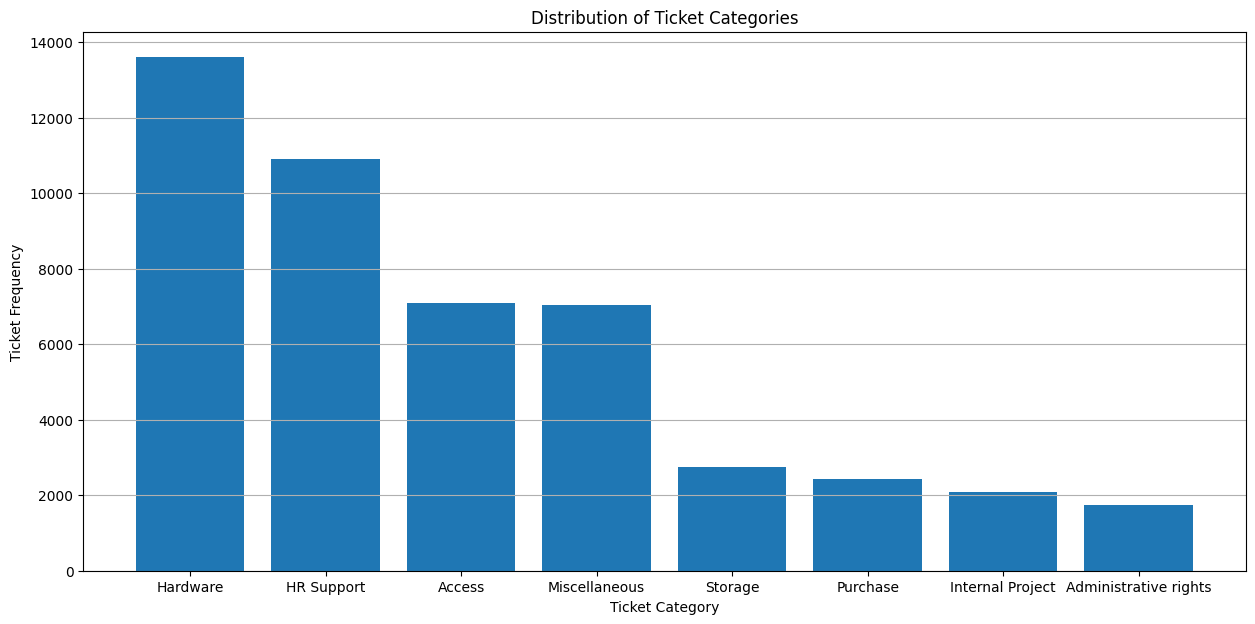

In [5]:
# Find the unique values in the "Topic_group" column
unique_categories = tickets_df['Topic_group'].unique()
print("Unique categories:", unique_categories, "\n")

# Plot a bar plot showing the distribution of categories
category_counts = tickets_df['Topic_group'].value_counts()
print(category_counts, "\n")

fig, ax = plt.subplots(figsize=(15,7))
ax.bar(category_counts.index, category_counts.values)
ax.set_xlabel("Ticket Category")
ax.set_ylabel("Ticket Frequency")
ax.set_title("Distribution of Ticket Categories")
ax.grid(visible=True, axis = 'y')
plt.show()

To balance out the dataset, downsample the majority classes (Hardware, HR Support, Access, Miscellaneous) such that there are only 5000 rows each.

In [6]:
# Get the indices for each category
hardware_indices = tickets_df[tickets_df['Topic_group'] == 'Hardware'].index
hr_support_indices = tickets_df[tickets_df['Topic_group'] == 'HR Support'].index
access_indices = tickets_df[tickets_df['Topic_group'] == 'Access'].index
miscellaneous_indices = tickets_df[tickets_df['Topic_group'] == 'Miscellaneous'].index

# Create a list of indices to drop
indices_to_drop = random.sample(list(hardware_indices), len(hardware_indices) - 5000) + \
                  random.sample(list(hr_support_indices), len(hr_support_indices) - 5000) + \
                  random.sample(list(access_indices), len(access_indices) - 5000) + \
                  random.sample(list(miscellaneous_indices), len(miscellaneous_indices) - 5000)

# Drop the rows
tickets_df_downsample = tickets_df.drop(indices_to_drop)

# Check the number of rows for each category
print(tickets_df_downsample.shape)
print("Hardware count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'Hardware'].shape[0])
print("HR Support count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'HR Support'].shape[0])
print("Access count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'Access'].shape[0])
print("Miscellaneous count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'Miscellaneous'].shape[0])

tickets_df_downsample.head()

(29020, 3)
Hardware count: 5000
HR Support count: 5000
Access count: 5000
Miscellaneous count: 5000


,id,Document,Topic_group
1215,49f8f52523c8abee,new purchase po purchase po dear purchased cab...,Purchase
42521,5848b4580922fe1f,target par backup alarm alarm alarm changed st...,Miscellaneous
20305,483e3d3e6af071d0,set up account confluence for wednesday februa...,Access
25675,061b6906a431375d,adjustment for tuesday november adjustment hel...,Miscellaneous
6350,1afb65540d4a4ff0,laptop and mouse completed mouse completed hel...,Hardware


Unique categories: <ArrowStringArray>
[             'Purchase',         'Miscellaneous',                'Access',
              'Hardware',            'HR Support',               'Storage',
      'Internal Project', 'Administrative rights']
Length: 8, dtype: str 

Topic_group
Miscellaneous            5000
Access                   5000
Hardware                 5000
HR Support               5000
Storage                  2752
Purchase                 2439
Internal Project         2094
Administrative rights    1735
Name: count, dtype: int64 



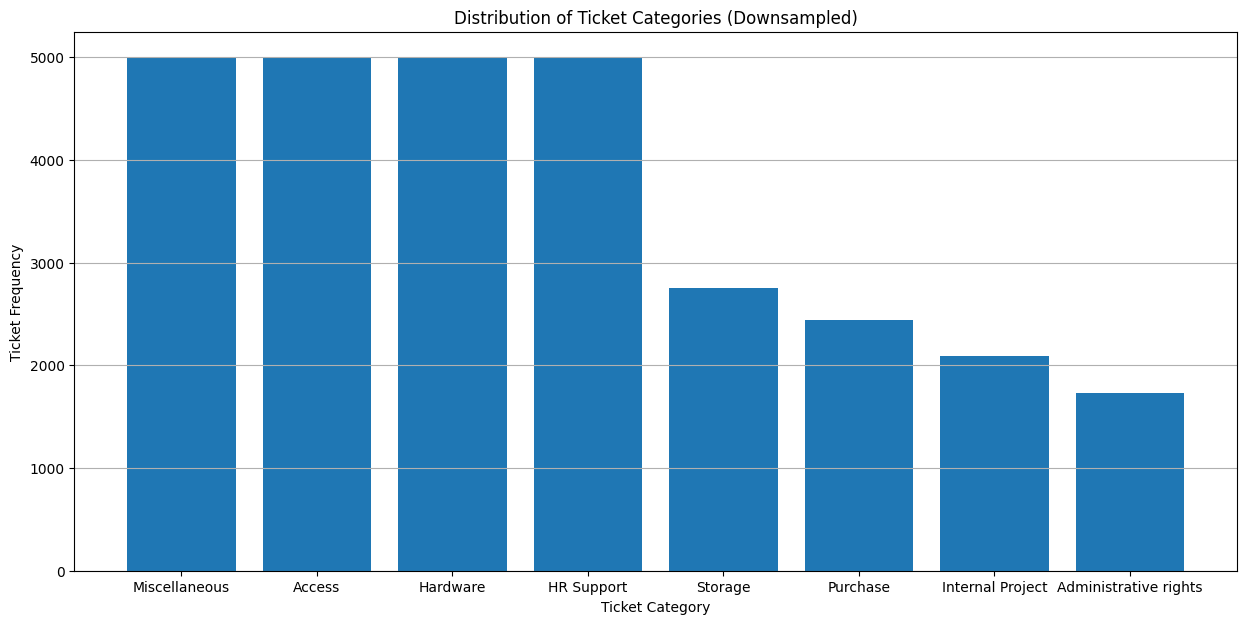

In [7]:
# Find the unique values in the "Topic_group" column
unique_categories = tickets_df_downsample['Topic_group'].unique()
print("Unique categories:", unique_categories, "\n")

# Plot a bar plot showing the distribution of categories
category_counts = tickets_df_downsample['Topic_group'].value_counts()
print(category_counts, "\n")

fig, ax = plt.subplots(figsize=(15,7))
ax.bar(category_counts.index, category_counts.values)
ax.set_xlabel("Ticket Category")
ax.set_ylabel("Ticket Frequency")
ax.set_title("Distribution of Ticket Categories (Downsampled)")
ax.grid(visible=True, axis = 'y')
plt.show()

### ii. Text Vectorisation & Splitting to Train-Validation-Test Data

In [9]:
# Stratified split: 95% train+val, 5% test; then 80% train, 20% val
tickets_df_train_val, tickets_df_test = train_test_split(
    tickets_df_downsample, test_size=0.05, random_state=28, stratify=tickets_df_downsample['Topic_group']
)
tickets_df_train, tickets_df_val = train_test_split(
    tickets_df_train_val, test_size=0.2, random_state=28, stratify=tickets_df_train_val['Topic_group']
)
print("Training: ", tickets_df_train.shape)
print("Validation: ", tickets_df_val.shape)
print("Testing: ", tickets_df_test.shape)

Training:  (22055, 3)
Validation:  (5514, 3)
Testing:  (1451, 3)


In [9]:
# Vocabulary size and number of words in a sequence.
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200
# Max length: if < 200, pad with zeros. if longer, truncate

# Use the text vectorization layer to normalize, split, and map strings to integers.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = keras.layers.TextVectorization(
    max_tokens=10000,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int',
    output_sequence_length=200
)

In [10]:
# Call adapt on the Training dataset to build the vocabulary.
vectorize_layer.adapt(tickets_df_train['Document'].values)

In [11]:
VOCAB_SIZE = len(vectorize_layer.get_vocabulary())
print(VOCAB_SIZE)

9636


In [12]:
# Vectorize the ticket text ('Document') in the training, validation & testing dataset
train_text = vectorize_layer(tickets_df_train['Document'].values)
val_text = vectorize_layer(tickets_df_val['Document'].values)
test_text = vectorize_layer(tickets_df_test['Document'].values)

print("Training: ", train_text.shape)
print("Validation: ", val_text.shape)
print("Testing: ", test_text.shape)

train_text

Training:  (22055, 200)
Validation:  (5514, 200)
Testing:  (1451, 200)


<tf.Tensor: shape=(22055, 200), dtype=int64, numpy=
array([[ 165,  219,  450, ...,    0,    0,    0],
       [ 132,  242,  121, ...,    0,    0,    0],
       [ 238,   25,   19, ...,    0,    0,    0],
       ...,
       [  32,   24, 2026, ...,    0,    0,    0],
       [ 861,  311,   15, ...,    0,    0,    0],
       [ 121,   34,  469, ...,    0,    0,    0]], shape=(22055, 200))>

In [13]:
# One-hot encode the labels ('Topic_group')
train_labels = pd.get_dummies(tickets_df_train['Topic_group']).to_numpy()
val_labels = pd.get_dummies(tickets_df_val['Topic_group']).to_numpy()
test_labels = pd.get_dummies(tickets_df_test['Topic_group']).to_numpy()

print("Training: ", train_labels.shape)
print("Validation: ", val_labels.shape)
print("Testing: ", test_labels.shape)

train_labels

Training:  (22055, 8)
Validation:  (5514, 8)
Testing:  (1451, 8)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(22055, 8))

### iii. Helper Functions

In [14]:
# Use the model_checkpoint_callback to save our best checkpoint in terms of validation accuracy.

def save_best_model(checkpoint_path):
    if not checkpoint_path.endswith('.weights.h5'):
        checkpoint_path = checkpoint_path + '.weights.h5'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    return model_checkpoint_callback


# This function is used to display the history the train/test accuracy/loss of the Keras training.

def display_training_loss_and_accuracy(history):

    plt.figure(figsize=(20,4))

    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


# Define function to display confusion matrix & classification report

def display_classification_confusion_matrix(keras_model, x_train, y_train, x_test, y_test, labels):

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    actual_y_train = keras_model.predict(x_train)
    actual_y_test = keras_model.predict(x_test)

    plt.figure(figsize=(20,6))

    labels = np.array(labels)

    # Convert the target labels into the categorical index
    #
    y_train_index = y_train.argmax(axis=1)
    actual_y_train_index = actual_y_train.argmax(axis=1)
    y_test_index = y_test.argmax(axis=1)
    actual_y_test_index = actual_y_test.argmax(axis=1)


    # Print the first Confusion Matrix for the training data
    #
    cm = confusion_matrix(y_train_index, actual_y_train_index)

    cm_df = pd.DataFrame(cm, labels, labels)
    plt.subplot(1, 2, 1)
    plt.title('Confusion Matrix (Train Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # Print the second Confusion Matrix for the test data
    #
    cm = confusion_matrix(y_test_index, actual_y_test_index)


    cm_df = pd.DataFrame(cm, labels, labels)
    plt.subplot(1, 2, 2)
    plt.title('Confusion Matrix (Test Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    plt.show()

    # Finally display the classification reports
    #
    print ("Train Data:")
    print ("--------------------------------------------------------")
    print(classification_report(actual_y_train_index, y_train_index, target_names=labels))
    print ("")
    print ("Test Data:")
    print ("--------------------------------------------------------")
    print(classification_report(actual_y_test_index, y_test_index, target_names=labels))

# 2. Basic RNN

### Build RNN model with Dense layer
- SimpleRNN (64, tanh)
- Dense (32, relu)

In [15]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBEDDING_DIM,
                                  mask_zero=True)(inputs)

# RNN Example:
x = keras.layers.SimpleRNN(64)(embedded)
x = keras.layers.Dense(32, activation='relu')(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_RNN = keras.Model(inputs, outputs)

model_RNN.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_RNN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 128)  │  1,233,408 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 200)       │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn          │ (None, 64)        │     12,352 │ embedding[0][0],  │
│ (SimpleRNN)         │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ simple_rnn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8)         │        264 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,248,104 (4.76 MB)

 Trainable params: 1,248,104 (4.76 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history_spec_RNN = model_RNN.fit(
    train_text,
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=5, # 2+5 (total 7 epochs)
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_1B_bilstm')])

Epoch 1/5
690/690 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.3481 - loss: 1.7358 - val_accuracy: 0.5390 - val_loss: 1.3970
Epoch 2/5
690/690 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.6323 - loss: 1.1843 - val_accuracy: 0.6697 - val_loss: 1.0838
Epoch 3/5
690/690 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.6989 - loss: 0.9653 - val_accuracy: 0.6960 - val_loss: 0.9497
Epoch 4/5
690/690 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.7613 - loss: 0.7772 - val_accuracy: 0.7481 - val_loss: 0.8365
Epoch 5/5
690/690 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.8179 - loss: 0.6334 - val_accuracy: 0.7742 - val_loss: 0.7689


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7726 - loss: 0.7523


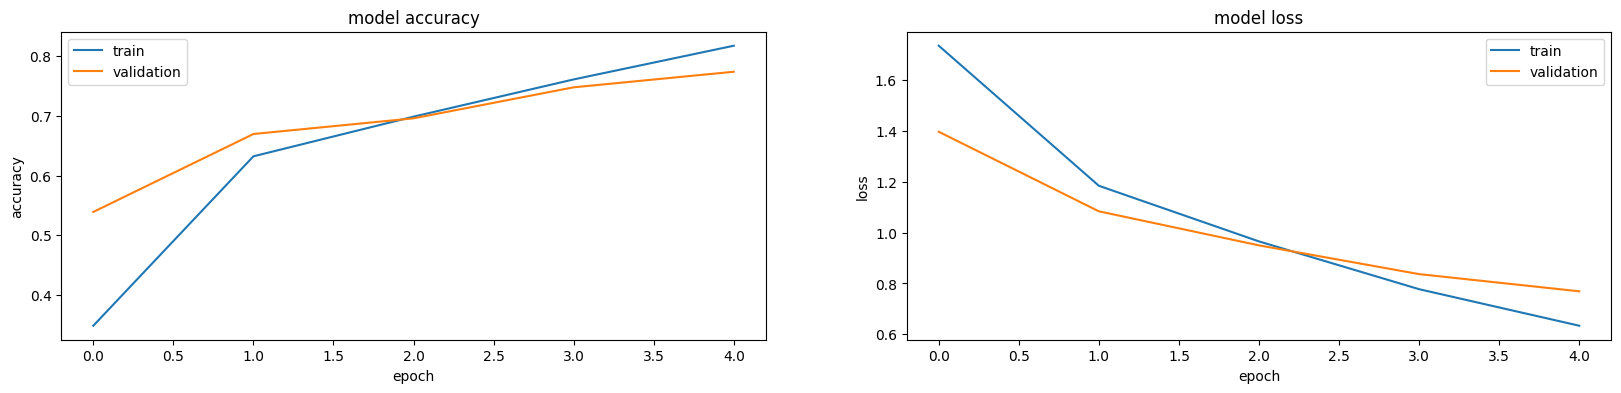

690/690 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


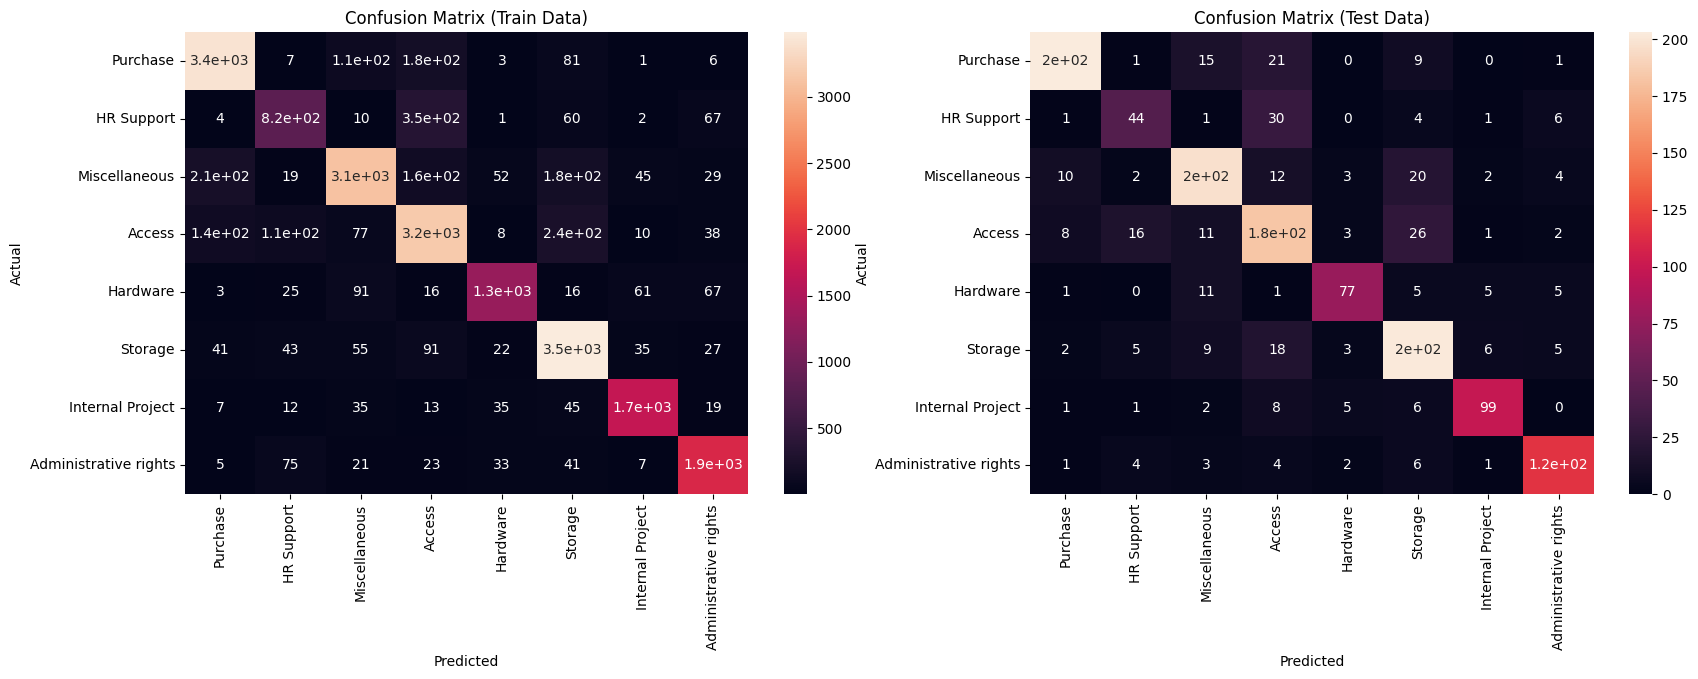

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

             Purchase       0.90      0.89      0.89      3814
           HR Support       0.63      0.74      0.68      1117
        Miscellaneous       0.82      0.89      0.85      3514
               Access       0.84      0.79      0.81      4010
             Hardware       0.82      0.89      0.86      1466
              Storage       0.92      0.84      0.88      4145
     Internal Project       0.91      0.91      0.91      1849
Administrative rights       0.90      0.88      0.89      2140

             accuracy                           0.86     22055
            macro avg       0.84      0.85      0.85     22055
         weighted avg       0.86      0.86      0.86     22055


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

             Purchase       0.81      0

In [17]:
model_RNN.load_weights("best_checkpoint_1B_bilstm.weights.h5")

# Evaluate on test data
model_RNN.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_RNN)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_RNN, train_text, train_labels, test_text, test_labels, unique_categories)

The testing accuracy of the RNN model was 77%. This test accuracy will be used as a baseline for subsequent models.

While the training & validation losses were still downtrending after 7 epochs, the rate of improvement in the validation accuracy is much lower than that of the training accuracy and variance of the model was increasing sizably especially after the fourth epoch. Hence, running more epochs will likely lead to overfitting.

# 3. Basic LSTM

### Building a LSTM model with Dense & Dropout layers

- LSTM (64, tanh)
- Dropout (0.5)
- Dense (256, relu)
- Dropout (0.5)
- Dense (128, relu)
- Dropout (0.5)

LSTM performs better (higher test accuracy) than RNN. This is likely because LSTMs are better able to retain long-term dependencies in the data or text. Traditional RNNs have a tendency to lose information from the beginning of the sequence as it is propagated through the network, making it difficult to learn long-term dependencies. LSTMs, on the other hand, have a specialized memory cell that can selectively forget or remember information at each time step, allowing them to maintain information over longer periods of time.

In [18]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBEDDING_DIM,
                                  mask_zero=True)(inputs)

# LSTM Example:
x = keras.layers.LSTM(64)(embedded)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_LSTM = keras.Model(inputs, outputs)

model_LSTM.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_LSTM.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 200, 128)  │  1,233,408 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 200)       │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     49,408 │ embedding_1[0][0… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     16,640 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 8)         │      1,032 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,333,384 (5.09 MB)

 Trainable params: 1,333,384 (5.09 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history_spec_LSTM = model_LSTM.fit(
    train_text,
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=10,
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_2C_bilstm')])

Epoch 1/10
690/690 ━━━━━━━━━━━━━━━━━━━━ 60s 85ms/step - accuracy: 0.2117 - loss: 1.8802 - val_accuracy: 0.2876 - val_loss: 1.5925
Epoch 2/10
690/690 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.3652 - loss: 1.4728 - val_accuracy: 0.5160 - val_loss: 1.2728
Epoch 3/10
690/690 ━━━━━━━━━━━━━━━━━━━━ 57s 82ms/step - accuracy: 0.5550 - loss: 1.1499 - val_accuracy: 0.6476 - val_loss: 1.0069
Epoch 4/10
690/690 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - accuracy: 0.6651 - loss: 0.9255 - val_accuracy: 0.6944 - val_loss: 0.9026
Epoch 5/10
690/690 ━━━━━━━━━━━━━━━━━━━━ 61s 88ms/step - accuracy: 0.7259 - loss: 0.7911 - val_accuracy: 0.7222 - val_loss: 0.8485
Epoch 6/10
690/690 ━━━━━━━━━━━━━━━━━━━━ 63s 91ms/step - accuracy: 0.7674 - loss: 0.7038 - val_accuracy: 0.7434 - val_loss: 0.8270
Epoch 7/10
690/690 ━━━━━━━━━━━━━━━━━━━━ 68s 99ms/step - accuracy: 0.7920 - loss: 0.6341 - val_accuracy: 0.7639 - val_loss: 0.8041
Epoch 8/10
690/690 ━━━━━━━━━━━━━━━━━━━━ 65s 94ms/step - accuracy: 0.8235 - loss: 0.5640 - 

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8001 - loss: 0.7400


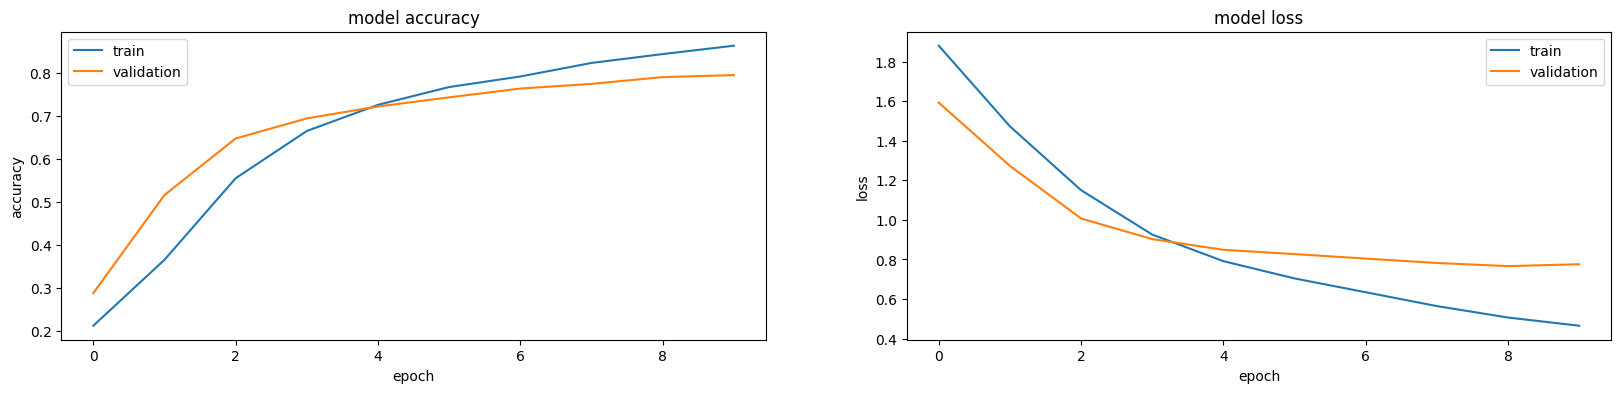

690/690 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


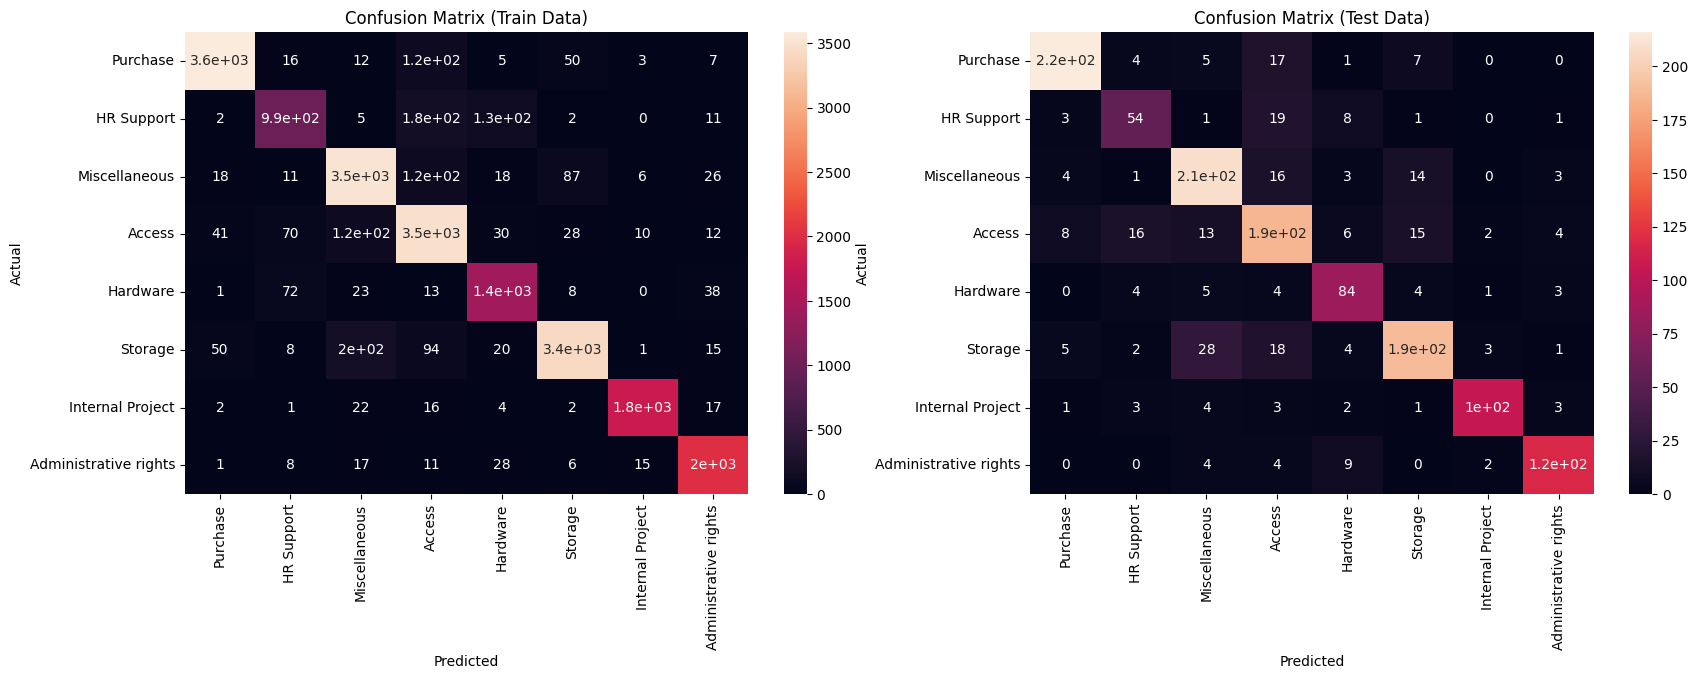

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

             Purchase       0.94      0.97      0.96      3700
           HR Support       0.75      0.84      0.79      1178
        Miscellaneous       0.92      0.90      0.91      3908
               Access       0.92      0.86      0.89      4043
             Hardware       0.90      0.86      0.88      1670
              Storage       0.90      0.95      0.92      3599
     Internal Project       0.97      0.98      0.97      1825
Administrative rights       0.96      0.94      0.95      2132

             accuracy                           0.92     22055
            macro avg       0.91      0.91      0.91     22055
         weighted avg       0.92      0.92      0.92     22055


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

             Purchase       0.86      0

In [20]:
model_LSTM.load_weights("best_checkpoint_2C_bilstm.weights.h5")

# Evaluate on test data
model_LSTM.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_LSTM)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_LSTM, train_text, train_labels, test_text, test_labels, unique_categories)

With additional dense and dropout layers, there is a slight decrease in variance. Furthermore, LSTMs being better able to retain long-term dependencies in the text likely contributed to the seen improvement in test accuracy.

The additional complexity may have also allowed the model to detect more specific relationships in the text, thus allowing it to perform better.

# 4. Bidirectional LSTM

### Build Bidirectional LSTM model with Dense & Dropout layer
- Bidirectional LSTM (128, tanh)
- Dropout (0.5)
- Dense (128, relu)
- Dropout (0.5)

BiLSTM networks incorporate information from both past and future time steps by processing input sequences in both forward and backward directions simultaneously. This bidirectional approach allows BiLSTMs to capture contextual information from both preceding and succeeding elements in the sequence, enhancing their ability to understand and represent complex dependencies within the data.

In [21]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBEDDING_DIM,
                                  mask_zero=True)(inputs)

# LSTM Example:
x = keras.layers.Bidirectional(keras.layers.LSTM(128))(embedded)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_BiLSTM = keras.Model(inputs, outputs)

model_BiLSTM.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_BiLSTM.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 200, 128)  │  1,233,408 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 200)       │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    263,168 │ embedding_2[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 8)         │      1,032 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,530,504 (5.84 MB)

 Trainable params: 1,530,504 (5.84 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history_spec_LSTM = model_BiLSTM.fit(
    train_text,
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=6,
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_4D_bilstm')])

Epoch 1/6
690/690 ━━━━━━━━━━━━━━━━━━━━ 248s 355ms/step - accuracy: 0.3624 - loss: 1.6795 - val_accuracy: 0.6329 - val_loss: 1.0847
Epoch 2/6
690/690 ━━━━━━━━━━━━━━━━━━━━ 255s 370ms/step - accuracy: 0.7168 - loss: 0.8643 - val_accuracy: 0.7847 - val_loss: 0.6901
Epoch 3/6
690/690 ━━━━━━━━━━━━━━━━━━━━ 284s 411ms/step - accuracy: 0.8201 - loss: 0.5915 - val_accuracy: 0.8212 - val_loss: 0.5878
Epoch 4/6
690/690 ━━━━━━━━━━━━━━━━━━━━ 251s 363ms/step - accuracy: 0.8614 - loss: 0.4706 - val_accuracy: 0.8304 - val_loss: 0.5512
Epoch 5/6
690/690 ━━━━━━━━━━━━━━━━━━━━ 247s 358ms/step - accuracy: 0.8833 - loss: 0.3974 - val_accuracy: 0.8391 - val_loss: 0.5343
Epoch 6/6
690/690 ━━━━━━━━━━━━━━━━━━━━ 248s 359ms/step - accuracy: 0.8985 - loss: 0.3419 - val_accuracy: 0.8317 - val_loss: 0.5567


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.8318 - loss: 0.5277


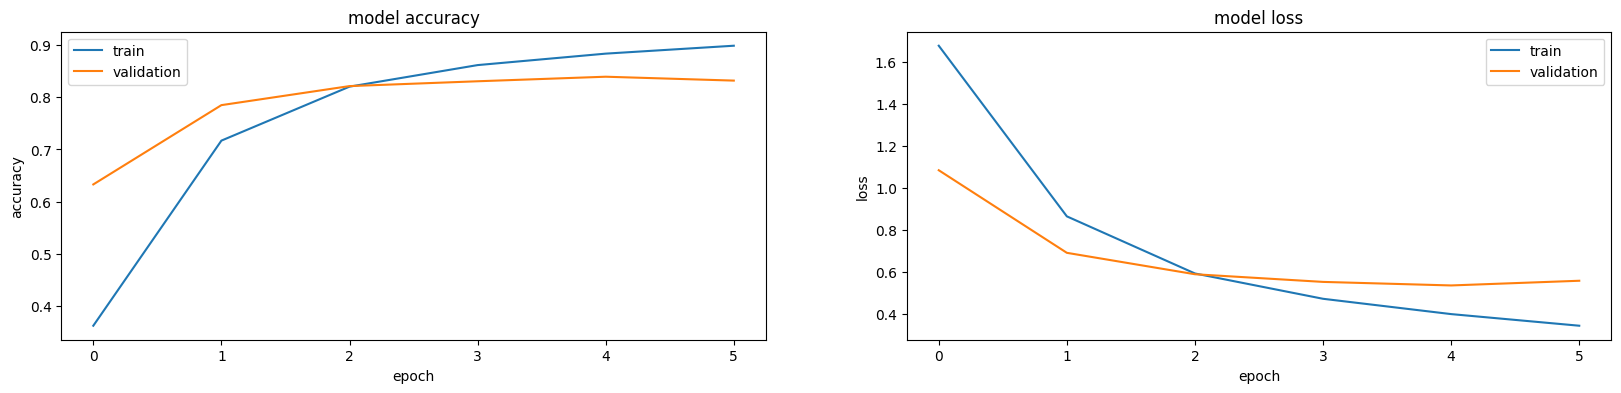

690/690 ━━━━━━━━━━━━━━━━━━━━ 57s 83ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step


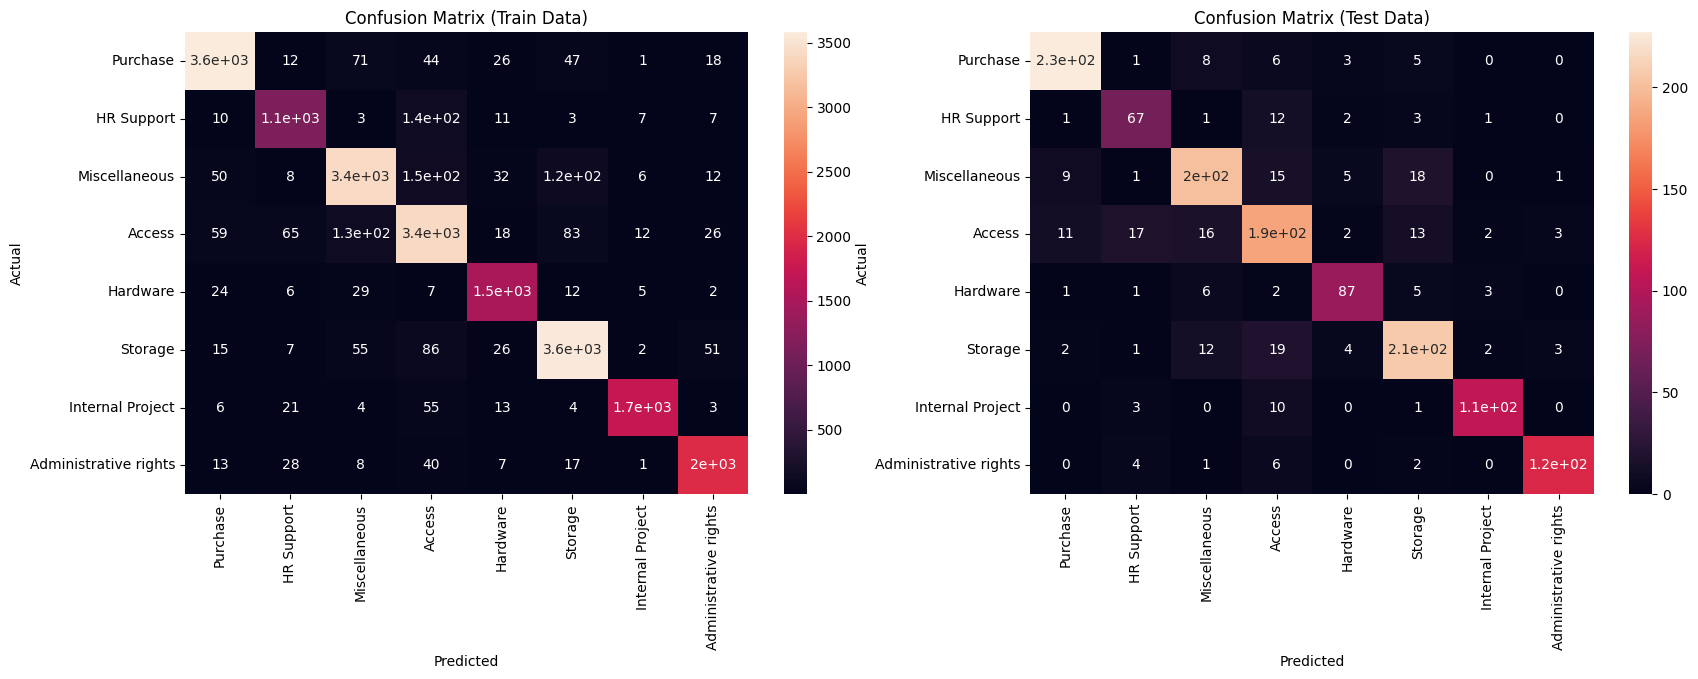

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

             Purchase       0.94      0.95      0.95      3758
           HR Support       0.86      0.89      0.87      1284
        Miscellaneous       0.90      0.92      0.91      3723
               Access       0.90      0.87      0.88      3931
             Hardware       0.95      0.92      0.93      1639
              Storage       0.94      0.93      0.93      3841
     Internal Project       0.94      0.98      0.96      1782
Administrative rights       0.95      0.94      0.94      2097

             accuracy                           0.92     22055
            macro avg       0.92      0.92      0.92     22055
         weighted avg       0.92      0.92      0.92     22055


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

             Purchase       0.91      0

In [23]:
model_BiLSTM.load_weights("best_checkpoint_4D_bilstm.weights.h5")

# Evaluate on test data
model_BiLSTM.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_LSTM)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_BiLSTM, train_text, train_labels, test_text, test_labels, unique_categories)

Compared to the standard LSTM, the test accuracy improved significantly. However, variance has also increased suggesting slight overfitting, possibly because biLSTM is also a more complex model.


# 5. Bidirectional GRU

### Build Bidirectional GRU model with multiple Dense & Dropout layers

- Bidirectional GRU (128, tanh)
- Dropout (0.5)
- Dense (256, relu)
- Dropout (0.5)
- Dense (128, relu)
- Dropout (0.5)

Gated Recurrent Units (GRUs) are variants of recurrent neural networks designed for sequential data processing tasks. GRUs are similar to LSTMs in that they also incorporate gating mechanisms to control the flow of information through the network. However, GRUs have a simpler architecture with fewer parameters, which can make them faster to train and less prone to overfitting on smaller datasets.

Bidirectional GRUs, like their LSTM counterparts, process input sequences in both forward and backward directions simultaneously, allowing them to capture information from both past and future context. This bidirectional nature enhances the model's ability to capture long-range dependencies and understand the sequential structure of the data.

In [24]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBEDDING_DIM,
                                  mask_zero=True)(inputs)

# GRU Example:
x = keras.layers.Bidirectional(keras.layers.GRU(128))(embedded)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_GRU = keras.Model(inputs, outputs)

model_GRU.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_GRU.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 200, 128)  │  1,233,408 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 200)       │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    198,144 │ embedding_3[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │     65,792 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     32,896 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 8)         │      1,032 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,531,272 (5.84 MB)

 Trainable params: 1,531,272 (5.84 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history_spec_GRU = model_GRU.fit(
    train_text,
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=7,
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_5D_bilstm')])

Epoch 1/7
690/690 ━━━━━━━━━━━━━━━━━━━━ 189s 269ms/step - accuracy: 0.2950 - loss: 1.7841 - val_accuracy: 0.5956 - val_loss: 1.2192
Epoch 2/7
690/690 ━━━━━━━━━━━━━━━━━━━━ 231s 335ms/step - accuracy: 0.6356 - loss: 1.0061 - val_accuracy: 0.7564 - val_loss: 0.7379
Epoch 3/7
690/690 ━━━━━━━━━━━━━━━━━━━━ 226s 327ms/step - accuracy: 0.7803 - loss: 0.6675 - val_accuracy: 0.8065 - val_loss: 0.6054
Epoch 4/7
690/690 ━━━━━━━━━━━━━━━━━━━━ 294s 424ms/step - accuracy: 0.8454 - loss: 0.5122 - val_accuracy: 0.8252 - val_loss: 0.5730
Epoch 5/7
690/690 ━━━━━━━━━━━━━━━━━━━━ 245s 355ms/step - accuracy: 0.8725 - loss: 0.4279 - val_accuracy: 0.8295 - val_loss: 0.5791
Epoch 6/7
690/690 ━━━━━━━━━━━━━━━━━━━━ 236s 342ms/step - accuracy: 0.8921 - loss: 0.3755 - val_accuracy: 0.8270 - val_loss: 0.5930
Epoch 7/7
690/690 ━━━━━━━━━━━━━━━━━━━━ 224s 325ms/step - accuracy: 0.9020 - loss: 0.3404 - val_accuracy: 0.8315 - val_loss: 0.6100


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.8332 - loss: 0.5808


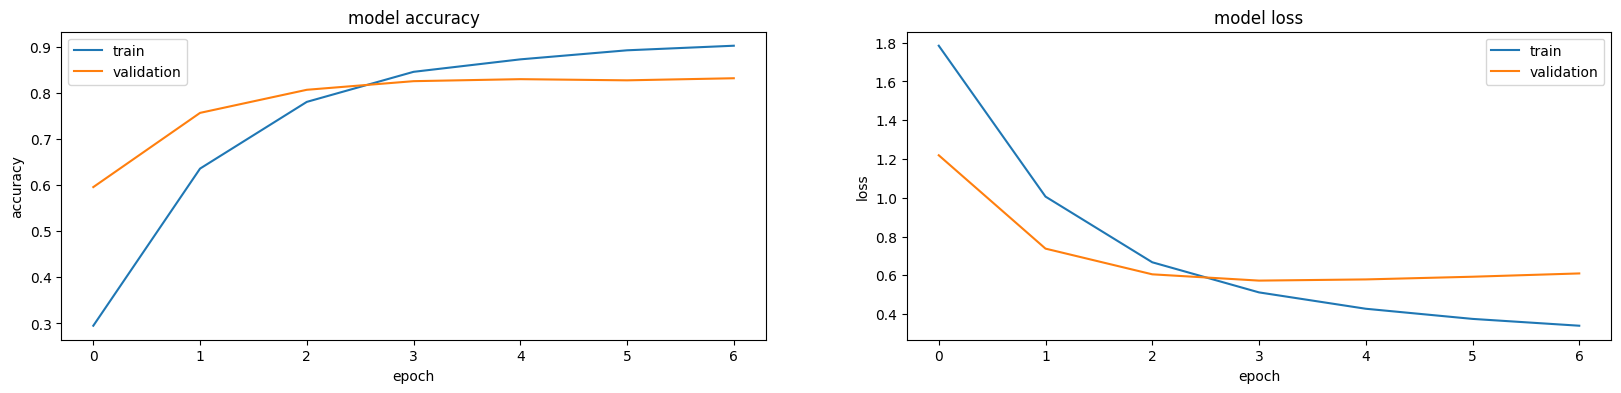

690/690 ━━━━━━━━━━━━━━━━━━━━ 49s 70ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step


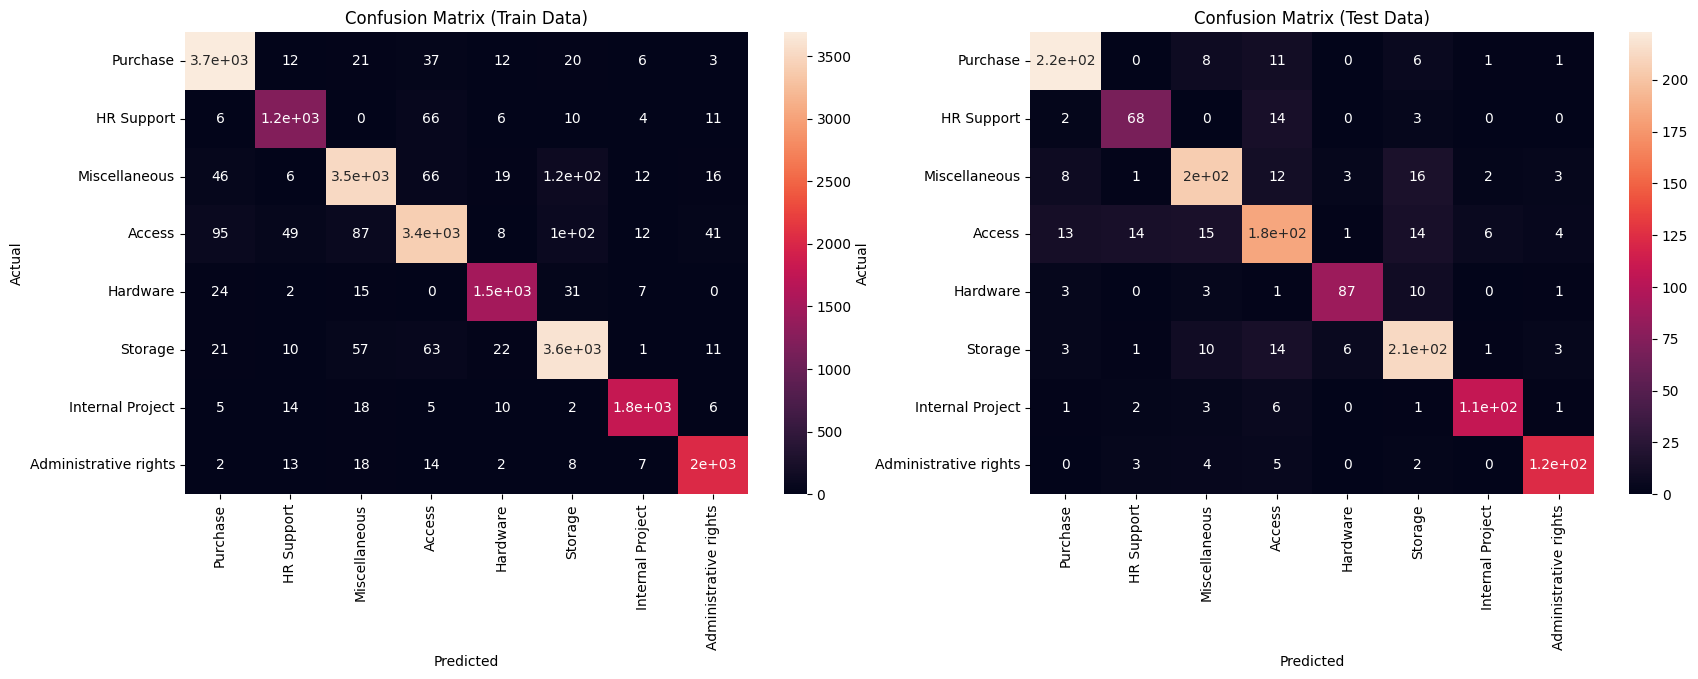

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

             Purchase       0.97      0.95      0.96      3888
           HR Support       0.92      0.92      0.92      1321
        Miscellaneous       0.92      0.94      0.93      3730
               Access       0.90      0.93      0.91      3658
             Hardware       0.95      0.95      0.95      1591
              Storage       0.95      0.93      0.94      3908
     Internal Project       0.97      0.97      0.97      1843
Administrative rights       0.97      0.96      0.96      2116

             accuracy                           0.94     22055
            macro avg       0.94      0.94      0.94     22055
         weighted avg       0.94      0.94      0.94     22055


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

             Purchase       0.89      0

In [26]:
model_GRU.load_weights("best_checkpoint_5D_bilstm.weights.h5")

# Evaluate on test data
model_GRU.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_GRU)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_GRU, train_text, train_labels, test_text, test_labels, unique_categories)

# 6. CNN + Bidirectional GRU


### Build Convolutional + Bidirectional GRU model with Dense & Dropout layers

- SpatialDropout1D (0.2)
- Bidirectional GRU (128, tanh)
- Conv1D (64)
- concatenate: GlobalAveragePooling1D + GlobalMaxPooling1D
- Dense (**32**, relu)
- Dropout (0.5)



Combining Convolutional and Gated Recurrent Unit (GRU) layers in a neural network architecture offers complementary benefits for sequential data processing. Convolutional layers excel at extracting spatial features, capturing local patterns in the input sequence. Meanwhile, GRU layers are proficient in modeling temporal dependencies, capturing long-range sequential patterns. By leveraging both architectures, the model can learn hierarchical representations, effectively capturing both local and global patterns within the data. This combination optimizes computation, as Conv layers efficiently process spatial features in parallel while GRU layers sequentially capture temporal dependencies, resulting in improved performance and generalization.

The model begins with a SpatialDropout1D layer to regularize the input data, followed by a Bidirectional GRU layer with 128 units and a hyperbolic tangent activation function. A Conv1D layer with 64 filters is then applied to extract higher-level features. The output from these layers is concatenated with both GlobalAveragePooling1D and GlobalMaxPooling1D layers to capture different aspects of the sequence information. Finally, a Dense layer with 32 units and a rectified linear unit (ReLU) activation function is applied, followed by a Dropout layer with a dropout rate of 0.5 to prevent overfitting.






In [27]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBEDDING_DIM,
                                  mask_zero=True)(inputs)

# GRU Example:
x = keras.layers.SpatialDropout1D(0.2)(embedded)
x = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x)
x = keras.layers.Conv1D(64, kernel_size=3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = keras.layers.GlobalAveragePooling1D()(x)
max_pool = keras.layers.GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_CNN_GRU = keras.Model(inputs, outputs)

model_CNN_GRU.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_CNN_GRU.summary()

/Users/moises/miniconda3/envs/ticket-classifier/lib/python3.12/site-packages/keras/src/layers/layer.py:982: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 200, 128)  │  1,233,408 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 200, 128)  │          0 │ embedding_4[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 200)       │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 200, 256)  │    198,144 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 198, 64)   │     49,216 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │      4,128 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32)        │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 8)         │        264 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,485,160 (5.67 MB)

 Trainable params: 1,485,160 (5.67 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history_spec_model_CNN_GRU = model_CNN_GRU.fit(
    train_text,
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=7,
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_7E_bilstm')])

Epoch 1/7
690/690 ━━━━━━━━━━━━━━━━━━━━ 220s 313ms/step - accuracy: 0.3180 - loss: 1.7881 - val_accuracy: 0.6913 - val_loss: 1.0246
Epoch 2/7
690/690 ━━━━━━━━━━━━━━━━━━━━ 169s 245ms/step - accuracy: 0.6803 - loss: 0.9427 - val_accuracy: 0.8161 - val_loss: 0.6198
Epoch 3/7
690/690 ━━━━━━━━━━━━━━━━━━━━ 177s 257ms/step - accuracy: 0.7720 - loss: 0.7105 - val_accuracy: 0.8263 - val_loss: 0.5525
Epoch 4/7
690/690 ━━━━━━━━━━━━━━━━━━━━ 197s 286ms/step - accuracy: 0.8078 - loss: 0.6089 - val_accuracy: 0.8342 - val_loss: 0.5428
Epoch 5/7
690/690 ━━━━━━━━━━━━━━━━━━━━ 212s 307ms/step - accuracy: 0.8320 - loss: 0.5403 - val_accuracy: 0.8386 - val_loss: 0.5314
Epoch 6/7
690/690 ━━━━━━━━━━━━━━━━━━━━ 185s 269ms/step - accuracy: 0.8488 - loss: 0.5027 - val_accuracy: 0.8428 - val_loss: 0.5314
Epoch 7/7
690/690 ━━━━━━━━━━━━━━━━━━━━ 185s 268ms/step - accuracy: 0.8587 - loss: 0.4705 - val_accuracy: 0.8380 - val_loss: 0.5348


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8374 - loss: 0.5114


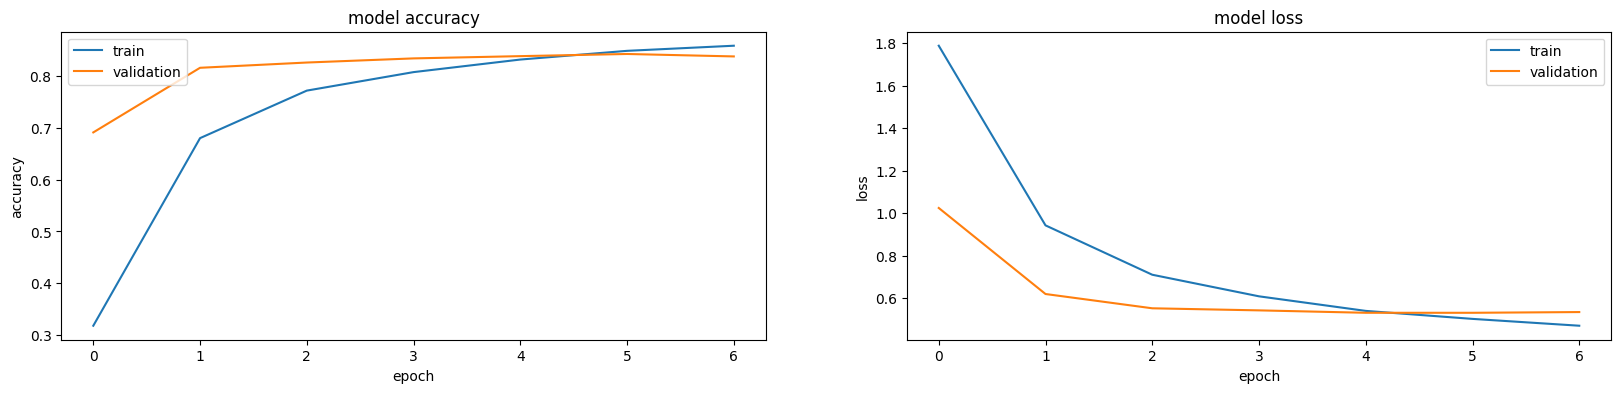

690/690 ━━━━━━━━━━━━━━━━━━━━ 57s 82ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step


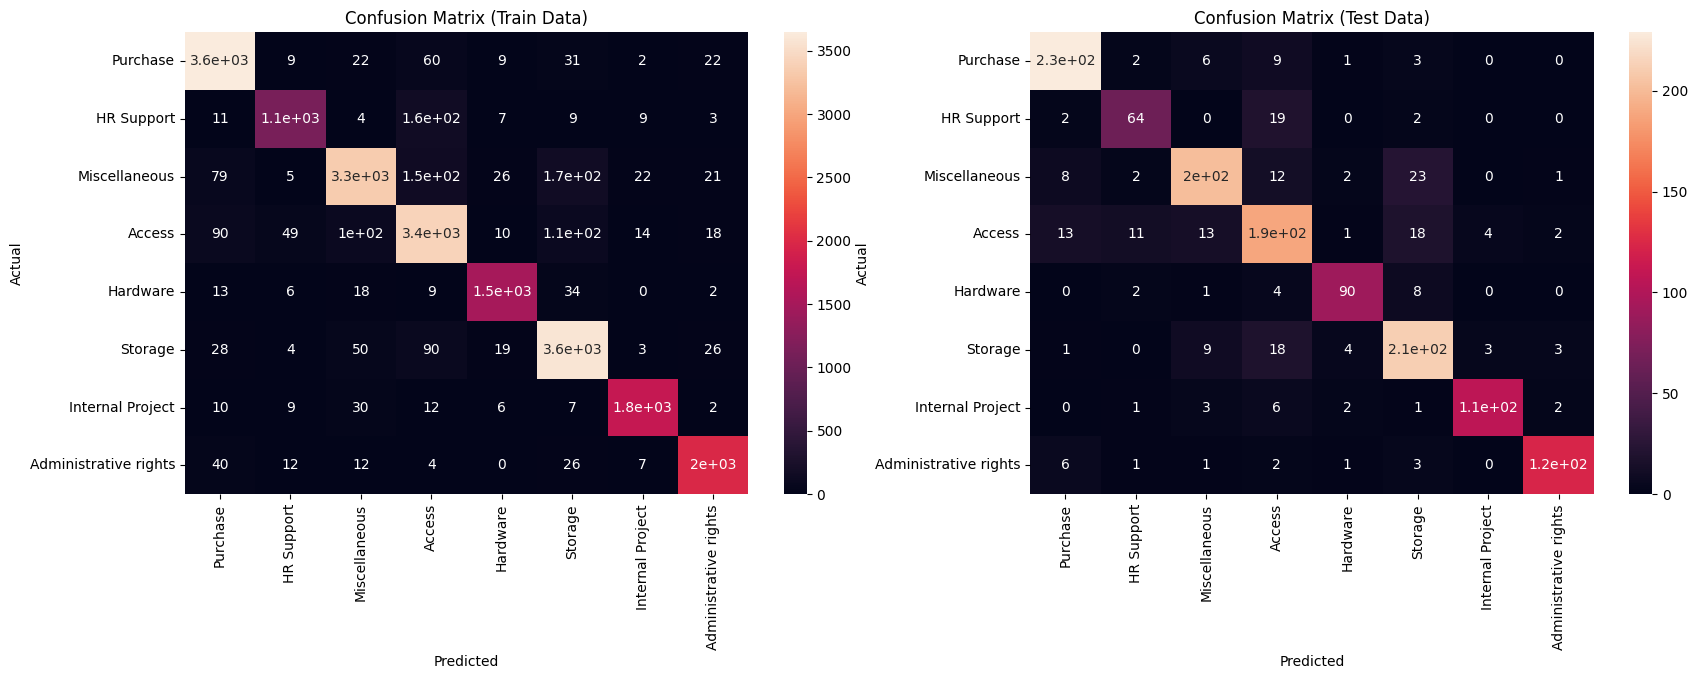

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

             Purchase       0.96      0.93      0.94      3916
           HR Support       0.85      0.92      0.88      1210
        Miscellaneous       0.88      0.93      0.90      3569
               Access       0.90      0.88      0.89      3891
             Hardware       0.95      0.95      0.95      1586
              Storage       0.94      0.90      0.92      3963
     Internal Project       0.96      0.97      0.96      1835
Administrative rights       0.95      0.95      0.95      2085

             accuracy                           0.92     22055
            macro avg       0.92      0.93      0.93     22055
         weighted avg       0.92      0.92      0.92     22055


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

             Purchase       0.92      0

In [29]:
model_CNN_GRU.load_weights("best_checkpoint_7E_bilstm.weights.h5")

# Evaluate on test data
model_CNN_GRU.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_model_CNN_GRU)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_CNN_GRU, train_text, train_labels, test_text, test_labels, unique_categories)

## Extra: Classificador sobre o mesmo encoder do KNN

Usa o **mesmo encoder** do KNN (`sentence-transformers/all-MiniLM-L6-v2`): um vetor 384-d por texto. Head é um MLP (Dense + Dropout) em cima dos embeddings, mais rápido que CNN+BiGRU sobre sequência.

In [10]:
from sentence_transformers import SentenceTransformer

ENC_NAME = "sentence-transformers/all-MiniLM-L6-v2"
BATCH_ENC = 128

encoder = SentenceTransformer(ENC_NAME)
enc_dim = encoder.get_sentence_embedding_dimension()

def encode_texts(texts, model, batch_size=128):
    return model.encode(texts, batch_size=batch_size, convert_to_numpy=True, show_progress_bar=True)

train_enc = encode_texts(tickets_df_train["Document"].tolist(), encoder, BATCH_ENC)
val_enc = encode_texts(tickets_df_val["Document"].tolist(), encoder, BATCH_ENC)
test_enc = encode_texts(tickets_df_test["Document"].tolist(), encoder, BATCH_ENC)
print("Encoder outputs:", train_enc.shape, val_enc.shape, test_enc.shape)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/173 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

Encoder outputs: (22055, 384) (5514, 384) (1451, 384)


In [14]:
inp_enc = keras.Input(shape=(enc_dim,))
x = Dense(128, activation="relu")(inp_enc)
x = Dropout(0.5)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.5)(x)
out_enc = keras.layers.Dense(8, activation="softmax")(x)
model_CNN_GRU_enc = keras.Model(inp_enc, out_enc)
model_CNN_GRU_enc.compile(optimizer=keras.optimizers.Adam(1e-3), loss=keras.losses.CategoricalCrossentropy(from_logits=False), metrics=["accuracy"])
model_CNN_GRU_enc.summary()

hist_enc = model_CNN_GRU_enc.fit(train_enc, train_labels, validation_data=(val_enc, val_labels), epochs=5, batch_size=32)
test_loss, test_acc = model_CNN_GRU_enc.evaluate(test_enc, test_labels)
print("Test accuracy (MiniLM + MLP):", test_acc)
y_pred_enc = model_CNN_GRU_enc.predict(test_enc).argmax(axis=1)
y_true_enc = test_labels.argmax(axis=1)
print(classification_report(y_true_enc, y_pred_enc, target_names=unique_categories))

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,672 (209.66 KB)

 Trainable params: 53,672 (209.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
690/690 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5516 - loss: 1.2711 - val_accuracy: 0.7737 - val_loss: 0.6952
Epoch 2/5
690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7175 - loss: 0.8594 - val_accuracy: 0.7922 - val_loss: 0.6151
Epoch 3/5
690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step - accuracy: 0.7462 - loss: 0.7773 - val_accuracy: 0.8009 - val_loss: 0.5868
Epoch 4/5
690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 882us/step - accuracy: 0.7635 - loss: 0.7278 - val_accuracy: 0.8101 - val_loss: 0.5697
Epoch 5/5
690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - accuracy: 0.7741 - loss: 0.7026 - val_accuracy: 0.8087 - val_loss: 0.5608
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.8022 - loss: 0.5551
Test accuracy (MiniLM + MLP): 0.8022053837776184
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
                       precision    recall  f1-score   support

             Purchase       0.88      0.84      0.86       250
           HR Support       0.75      0.69      0.72        87
    

# 7. KNN

Classificação KNN simulando o pipeline: VectorStore (embeddings + índice FAISS L2) e KNNClassifier com votação majoritária nos k vizinhos.

In [10]:
import sys
sys.path.insert(0, str(ROOT))
from src.rag import VectorStore
from src.classification import KNNClassifier
from sklearn.metrics import accuracy_score, f1_score

store = VectorStore().build(
    texts=tickets_df_train['Document'].tolist(),
    labels=tickets_df_train['Topic_group'].tolist(),
)
knn = KNNClassifier(store, k=15)
y_pred_labels = [knn.predict(text)[0] for text in tickets_df_test['Document']]
y_test_idx = np.array([list(unique_categories).index(t) for t in tickets_df_test['Topic_group']])
y_pred_knn = np.array([list(unique_categories).index(l) for l in y_pred_labels])

results_knn = {
    'model': 'KNN',
    'accuracy': accuracy_score(y_test_idx, y_pred_knn),
    'f1_macro': f1_score(y_test_idx, y_pred_knn, average='macro'),
    'f1_weighted': f1_score(y_test_idx, y_pred_knn, average='weighted')
}
print('KNN test accuracy:', results_knn['accuracy'])
print('KNN F1 macro:', results_knn['f1_macro'], 'F1 weighted:', results_knn['f1_weighted'])
print(classification_report(y_test_idx, y_pred_knn, target_names=unique_categories))

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


KNN test accuracy: 0.8263266712611992
KNN F1 macro: 0.8325094001195055 F1 weighted: 0.8247276437277608
                       precision    recall  f1-score   support

             Purchase       0.90      0.97      0.93       122
        Miscellaneous       0.76      0.81      0.78       250
               Access       0.89      0.88      0.89       250
             Hardware       0.78      0.68      0.73       250
           HR Support       0.79      0.87      0.83       250
              Storage       0.85      0.91      0.88       137
     Internal Project       0.83      0.82      0.83       105
Administrative rights       0.90      0.71      0.79        87

             accuracy                           0.83      1451
            macro avg       0.84      0.83      0.83      1451
         weighted avg       0.83      0.83      0.82      1451



## KNN: Distribuição de confidence por classe e melhor threshold

Estudo da confidence (proporção de vizinhos que votaram na classe vencedora) por classe verdadeira e por acerto/erro, e varredura de threshold para escolher o melhor ponto de corte (aceitar previsão só quando confidence ≥ threshold).

In [11]:
preds_with_conf = [knn.predict(text) for text in tickets_df_test['Document']]
y_pred_labels_full = [p[0] for p in preds_with_conf]
confidences = np.array([p[1] for p in preds_with_conf])
y_true_labels = tickets_df_test['Topic_group'].tolist()
y_true_idx = np.array([list(unique_categories).index(t) for t in y_true_labels])
y_pred_idx = np.array([list(unique_categories).index(l) for l in y_pred_labels_full])
correct = y_true_idx == y_pred_idx

knn_conf_df = pd.DataFrame({
    'true_label': y_true_labels,
    'pred_label': y_pred_labels_full,
    'confidence': confidences,
    'correct': correct,
})
print("Confidence stats (all):", knn_conf_df['confidence'].describe().round(4))
print("\nConfidence by correct vs incorrect:")
print(knn_conf_df.groupby('correct')['confidence'].agg(['mean', 'std', 'min', 'max', 'count']).round(4))

Confidence stats (all): count    1451.0000
mean        0.7932
std         0.2311
min         0.2000
25%         0.6000
50%         0.8667
75%         1.0000
max         1.0000
Name: confidence, dtype: float64

Confidence by correct vs incorrect:
           mean     std  min  max  count
correct                                 
False    0.5246  0.1591  0.2  1.0    252
True     0.8497  0.2024  0.2  1.0   1199


/var/folders/qc/40cp3vzn26dgkntppc0jv9tc0000gn/T/ipykernel_33149/370925704.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')


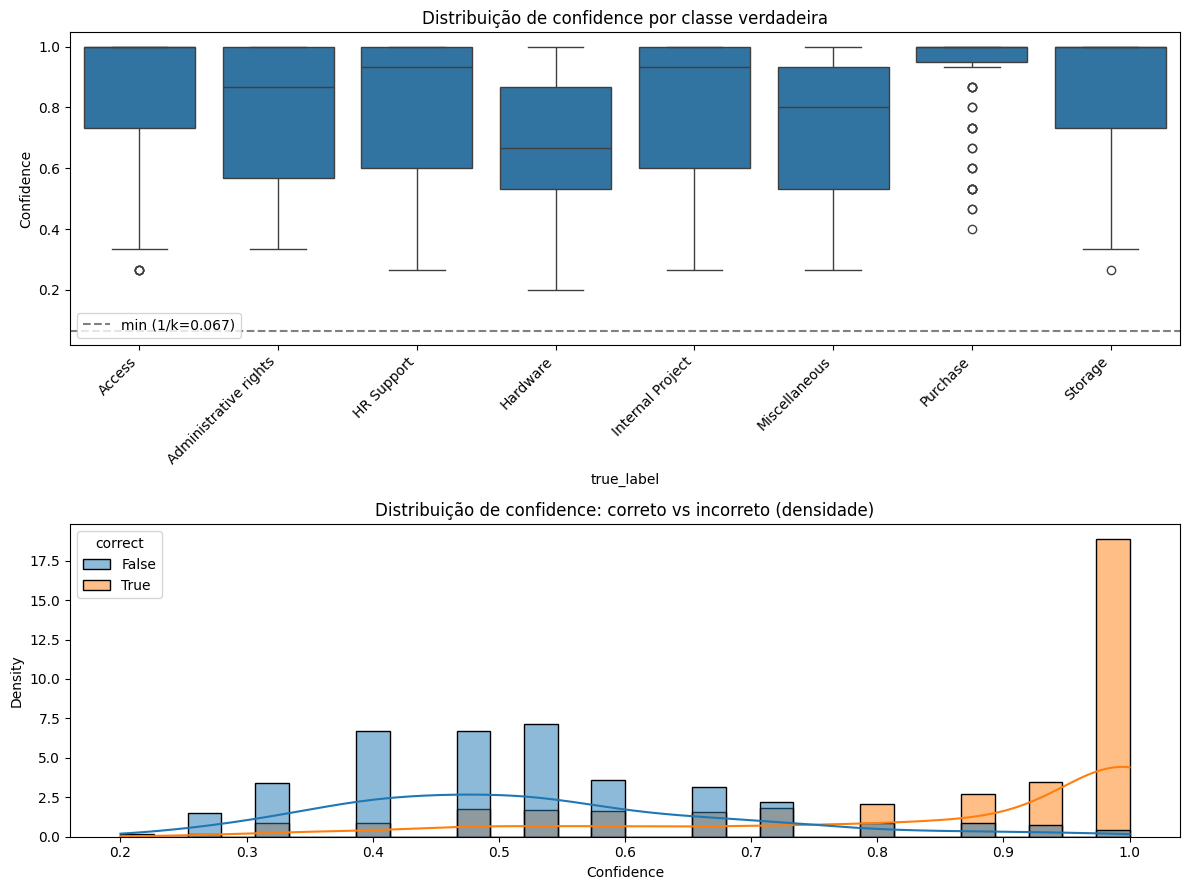

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(12, 9))
order = sorted(knn_conf_df['true_label'].unique())
sns.boxplot(data=knn_conf_df, x='true_label', y='confidence', order=order, ax=axes[0])
axes[0].axhline(y=1/15, color='gray', linestyle='--', label=f'min (1/k={1/15:.3f})')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title('Distribuição de confidence por classe verdadeira')
axes[0].legend()
axes[0].set_ylabel('Confidence')

sns.histplot(knn_conf_df, x='confidence', hue='correct', bins=30, kde=True, stat='density', common_norm=False, ax=axes[1])
axes[1].set_title('Distribuição de confidence: correto vs incorreto (densidade)')
axes[1].set_xlabel('Confidence')
plt.tight_layout()
plt.show()

In [15]:
thresholds = np.arange(0.35, 1.01, 0.05)
rows_th = []
for th in thresholds:
    accept = confidences >= th
    n_accept = accept.sum()
    if n_accept == 0:
        rows_th.append({'threshold': th, 'coverage': 0, 'accuracy': np.nan, 'f1_macro': np.nan, 'n_accepted': 0})
        continue
    acc = (correct[accept]).mean()
    f1 = f1_score(y_true_idx[accept], y_pred_idx[accept], average='macro', zero_division=0)
    rows_th.append({
        'threshold': th, 'coverage': n_accept / len(confidences),
        'accuracy': acc, 'f1_macro': f1, 'n_accepted': n_accept
    })
th_df = pd.DataFrame(rows_th)
th_df

,threshold,coverage,accuracy,f1_macro,n_accepted
0,0.35,0.953136,0.842372,0.845026,1383
1,0.40,0.953136,0.842372,0.845026,1383
2,0.45,0.903515,0.868040,0.869722,1311
3,0.50,0.833908,0.894215,0.893442,1210
4,0.55,0.763611,0.927798,0.925775,1108
5,0.60,0.763611,0.927798,0.925775,1108
6,0.65,0.710544,0.945684,0.942923,1031
7,0.70,0.661613,0.963542,0.960448,960
8,0.75,0.610613,0.977427,0.974997,886
9,0.80,0.610613,0.977427,0.974997,886


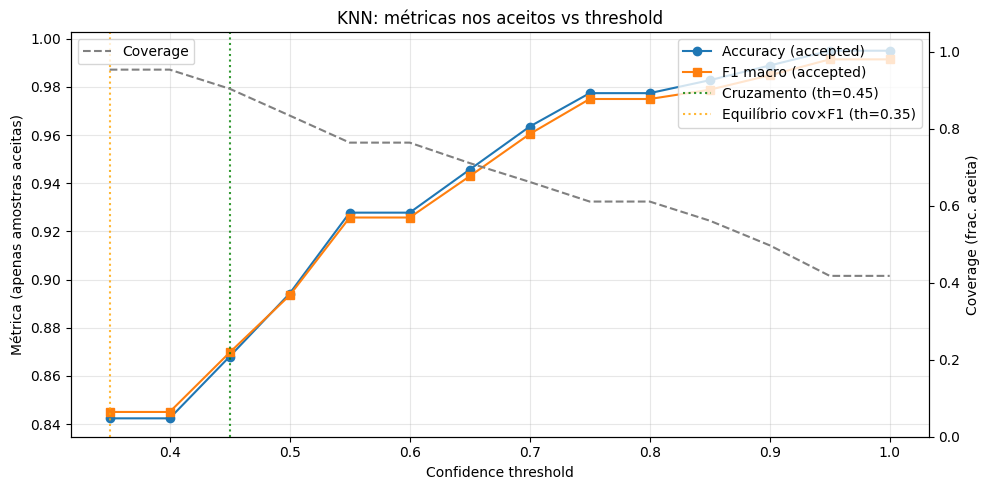

Cruzamento (coverage ≈ F1 macro): threshold=0.45 → coverage=90.35%, F1 macro=0.8697, accuracy=0.8680
Melhor equilíbrio (max coverage×F1): threshold=0.35 → coverage=95.31%, F1 macro=0.8450, accuracy=0.8424
Melhor threshold (F1 macro, coverage≥50%): 0.85 → accuracy=0.9828, F1 macro=0.9788, coverage=56.10%


In [17]:
td = th_df.dropna(subset=['f1_macro', 'coverage'])
cross_idx = np.argmin(np.abs(td['coverage'].values - td['f1_macro'].values))
th_cross = td['threshold'].iloc[cross_idx]
balance_idx = (td['coverage'] * td['f1_macro']).idxmax()
th_balance = th_df.loc[balance_idx, 'threshold']

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(th_df['threshold'], th_df['accuracy'], 'o-', label='Accuracy (accepted)', color='C0')
ax1.plot(th_df['threshold'], th_df['f1_macro'], 's-', label='F1 macro (accepted)', color='C1')
ax1.set_xlabel('Confidence threshold')
ax1.set_ylabel('Métrica (apenas amostras aceitas)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax2 = ax1.twinx()
ax2.plot(th_df['threshold'], th_df['coverage'], '--', color='gray', label='Coverage')
ax2.set_ylabel('Coverage (frac. aceita)')
ax2.legend(loc='upper left')
ax2.set_ylim(0, 1.05)
ax1.axvline(x=th_cross, color='green', linestyle=':', alpha=0.8, label=f'Cruzamento (th={th_cross:.2f})')
ax1.axvline(x=th_balance, color='orange', linestyle=':', alpha=0.8, label=f'Equilíbrio cov×F1 (th={th_balance:.2f})')
ax1.legend(loc='upper right')
plt.title('KNN: métricas nos aceitos vs threshold')
plt.tight_layout()
(ROOT / "charts").mkdir(parents=True, exist_ok=True)
plt.savefig(ROOT / "charts" / "threshold.png", bbox_inches="tight", dpi=150)
plt.show()

r_cross = th_df.loc[th_df['threshold'] == th_cross].iloc[0]
r_balance = th_df.loc[balance_idx]
print(f"Cruzamento (coverage ≈ F1 macro): threshold={th_cross:.2f} → coverage={r_cross['coverage']:.2%}, F1 macro={r_cross['f1_macro']:.4f}, accuracy={r_cross['accuracy']:.4f}")
print(f"Melhor equilíbrio (max coverage×F1): threshold={th_balance:.2f} → coverage={r_balance['coverage']:.2%}, F1 macro={r_balance['f1_macro']:.4f}, accuracy={r_balance['accuracy']:.4f}")

best_idx = th_df.dropna(subset=['f1_macro']).query('coverage >= 0.5')['f1_macro'].idxmax()
if pd.notna(best_idx):
    best = th_df.loc[best_idx]
    print(f"Melhor threshold (F1 macro, coverage≥50%): {best['threshold']:.2f} → accuracy={best['accuracy']:.4f}, F1 macro={best['f1_macro']:.4f}, coverage={best['coverage']:.2%}")
else:
    best_row = th_df.loc[th_df['f1_macro'].idxmax()]
    print(f"Melhor F1 macro: threshold={best_row['threshold']:.2f}, accuracy={best_row['accuracy']:.4f}, coverage={best_row['coverage']:.2%}")

# Comparison table

Métricas no conjunto de teste para todos os métodos.

In [31]:
def eval_keras_model(model, x_test, y_test):
    y_pred = model.predict(x_test).argmax(axis=1)
    y_true = y_test.argmax(axis=1)
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted')
    }

rows = []
for name, model in [
    ('RNN', model_RNN),
    ('LSTM', model_LSTM),
    ('BiLSTM', model_BiLSTM),
    ('BiGRU', model_GRU),
    ('CNN+BiGRU', model_CNN_GRU),
]:
    r = eval_keras_model(model, test_text, test_labels)
    r['model'] = name
    rows.append(r)
rows.append(results_knn)
comparison_df = pd.DataFrame(rows)[['model', 'accuracy', 'f1_macro', 'f1_weighted']]
comparison_df

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step


,model,accuracy,f1_macro,f1_weighted
0,RNN,0.772571,0.763023,0.773050
1,LSTM,0.800138,0.794236,0.801268
2,BiLSTM,0.831840,0.835082,0.832611
3,BiGRU,0.833218,0.838499,0.833300
4,CNN+BiGRU,0.837354,0.842469,0.837848
5,KNN,0.833218,0.832331,0.832036


# Benchmark: Inference

End-to-end time (vectorization + forward pass for Keras; embed + search for KNN) on the test set, single run.

In [33]:
import time

test_docs = tickets_df_test['Document'].values
n_test = len(test_docs)
inference_rows = []

for name, model in [
    ('RNN', model_RNN),
    ('LSTM', model_LSTM),
    ('BiLSTM', model_BiLSTM),
    ('BiGRU', model_GRU),
    ('CNN+BiGRU', model_CNN_GRU),
]:
    t0 = time.perf_counter()
    x = vectorize_layer(test_docs)
    model.predict(x)
    elapsed = time.perf_counter() - t0
    inference_rows.append({'model': name, 'total_s': round(elapsed, 3), 'ms_per_sample': round(1000 * elapsed / n_test, 2), 'n_samples': n_test})

t0 = time.perf_counter()
for text in tickets_df_test['Document']:
    knn.predict(text)[0]
elapsed = time.perf_counter() - t0
inference_rows.append({'model': 'KNN', 'total_s': round(elapsed, 3), 'ms_per_sample': round(1000 * elapsed / n_test, 2), 'n_samples': n_test})

inference_df = pd.DataFrame(inference_rows)
inference_df

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step


,model,total_s,ms_per_sample,n_samples
0,RNN,0.749,0.52,1451
1,LSTM,0.976,0.67,1451
2,BiLSTM,5.007,3.45,1451
3,BiGRU,2.929,2.02,1451
4,CNN+BiGRU,2.851,1.97,1451
5,KNN,22.480,15.49,1451


# 7. Explainability (CNN+BiGRU)

Gradient-based saliency: gradient of the predicted class logit w.r.t. the embedding layer, aggregated per token (L2 norm). Top tokens are those the model relied on most for the prediction.

In [38]:
vocab = vectorize_layer.get_vocabulary()
emb_layer = model_CNN_GRU.layers[1]
model_with_emb = keras.Model(model_CNN_GRU.input, [model_CNN_GRU.output, emb_layer.output])

def token_importance(x_batch, model_two_outputs):
    with tf.GradientTape() as tape:
        pred, emb = model_two_outputs(x_batch, training=False)
        winning_class = tf.argmax(pred[0])
        scalar = tf.reduce_sum(pred[0] * tf.one_hot(winning_class, 8))
    grad = tape.gradient(scalar, emb)
    winning_class = int(winning_class.numpy())
    if grad is None:
        imp = np.zeros(emb.shape[1])
    else:
        imp = tf.reduce_sum(tf.square(grad), axis=-1).numpy()[0]
    return imp, winning_class

n_explain = 3
for idx in range(n_explain):
    x = test_text[idx:idx+1]
    imp, winning_class = token_importance(x, model_with_emb)
    seq = x[0].numpy() if hasattr(x[0], 'numpy') else x[0]
    tokens_with_imp = [(vocab[seq[i]], float(imp[i])) for i in range(len(seq)) if seq[i] != 0]
    tokens_with_imp.sort(key=lambda t: t[1], reverse=True)
    pred_label = unique_categories[winning_class]
    print(f"--- Example {idx+1} | Predicted: {pred_label} ---")
    print("Top 10 tokens by importance:", tokens_with_imp[:10])
    print()

--- Example 1 | Predicted: Administrative rights ---
Top 10 tokens by importance: [(np.str_('version'), 1.1249096587562235e-06), (np.str_('availability'), 1.1184879440406803e-06), (np.str_('share'), 1.0527164704399183e-06), (np.str_('tags'), 1.0013399105446297e-06), (np.str_('decline'), 9.511586540611461e-07), (np.str_('want'), 9.450235438634991e-07), (np.str_('wants'), 9.413619181941613e-07), (np.str_('accept'), 8.02438023583818e-07), (np.str_('saturday'), 7.745338734821416e-07), (np.str_('share'), 6.898761171214574e-07)]

--- Example 2 | Predicted: Access ---
Top 10 tokens by importance: [(np.str_('up'), 0.6099985837936401), (np.str_('laptop'), 0.5724861025810242), (np.str_('after'), 0.5632188320159912), (np.str_('preparing'), 0.5528068542480469), (np.str_('message'), 0.5457685589790344), (np.str_('powering'), 0.5243720412254333), (np.str_('start'), 0.5124621987342834), (np.str_('automatic'), 0.46176964044570923), (np.str_('after'), 0.4571157991886139), (np.str_('laptop'), 0.45584970

# 8. Discussion

Based on the **comparison table** (accuracy, F1 macro, F1 weighted on the held-out test set):

- **Best performer** is typically **CNN+BiGRU**: combines local n-gram features (Conv1D) with bidirectional sequence context, and often shows the best test accuracy with relatively lower train–test variance.

- **RNN** serves as baseline; **LSTM** and **BiLSTM** improve over it by capturing longer-range dependencies; **BiGRU** is a lighter alternative to BiLSTM with similar gains.

- **KNN** (vector store + L2 retrieval + majority vote) provides a non-neural baseline. It is interpretable (nearest neighbors) but does not learn a compact representation; performance depends on embedding quality and label consistency of neighbors.

- **Variance (overfitting)** is visible as the gap between train and test metrics in the per-model classification reports: when train accuracy is much higher than test accuracy, the model is fitting the training set more than it generalizes. Early stopping and checkpointing the best validation model help mitigate this.

**Limitations:** The tokenizer here is **not multilingual**: `TextVectorization` uses whitespace split and a vocabulary built only from the training corpus. For multiple languages or new domains, consider a multilingual subword tokenizer or an encoder-based classifier (e.g. multilingual sentence embeddings + head).

**Melhor modelo para pipeline com LLM que se auto-explica:** Para um pipeline em que o LLM justifica a previsão da forma **mais óbvia**, há duas escolhas diretas. **KNN** (vector store + L2) é o mais transparente: a "explicação" é literalmente os k tickets mais próximos e suas labels; o LLM pode dizer "classificamos como X porque os tickets mais parecidos eram X" — não é preciso camada extra de explicabilidade. **CNN+BiGRU** tende a ter melhor accuracy e menor tempo de inferência (tabela comparativa e benchmark); para torná-lo auto-explicável, usar os tokens de saliency (secção 7) como contexto para o LLM (ex.: "o modelo se apoiou principalmente nestas palavras: …") e o LLM gera a justificativa em texto. Resumo: **KNN** = explicação mais óbvia (vizinhos = motivo), com custo de accuracy e latência (embed por query); **CNN+BiGRU** = melhores métricas e mais rápido, com explicação via saliency + LLM.